# Importing Libraries

In [1]:
from diff_weighted_fields import Grid1D, GaussianFieldGenerator1D, Zeldovich1D, PowerSpectrum, MCMC
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import jax
from tqdm import tqdm
from mycolorpy import colorlist as mcp
from diff_weighted_fields.utils import covariance_to_correlation_batch, covariance_to_correlation
plt.style.use('thesis.mplstyle')

#grid setup
L = 4000
N = 1024
dk     = 6  #units of kf 
kmin   = 4  #units of kf
R_smooth = 3  #units of cell size
kmax   = 0.5 #units of kNyq

#define the field and gaussian generator
grid = Grid1D((N,), L, R_clip = R_smooth)
mesh = Grid1D((N//2,), L, dk =dk, kmax = kmax , kmin =kmin, R_gauss = R_smooth*0)

Using clipping smoothing with R_clip = 3 cells (physical = 11.71875); k_smooth = 2.681e-01


In [2]:
print('Grid clip Properties:')
print(grid)

print('Mesh Properties:')
print(mesh)

Grid clip Properties:
Using Clipping smoothing with R_clip = 3
kmin: 0.0015707963267948967
kmax: 0.8042477193189871
dk: 0.0031415926535897933
N: 1024
Shape: (1024,)
L: 4000
Volume: 4000.0

Mesh Properties:
Using None smoothing
kmin: 0.006283185307179587
kmax: 0.20106192982974677
dk: 0.00942477796076938
N: 512
Shape: (512,)
L: 4000
Volume: 4000.0



In [3]:
def PK(k,theta, threshold = 0.001):
    A,R,n = theta
    physical_R = R * mesh.H[0]
    k_std = jnp.pi/physical_R
    _p = A*(k*R)**n*jnp.exp(-0.5*(k/k_std)**2)
    sig = jnp.max(_p)
    return _p + sig* threshold
A = 2.0
R_pk = 18. #units of cell size
n = 3.
theta = jnp.array([A, R_pk, n])

Text(0, 0.5, 'P(k)')

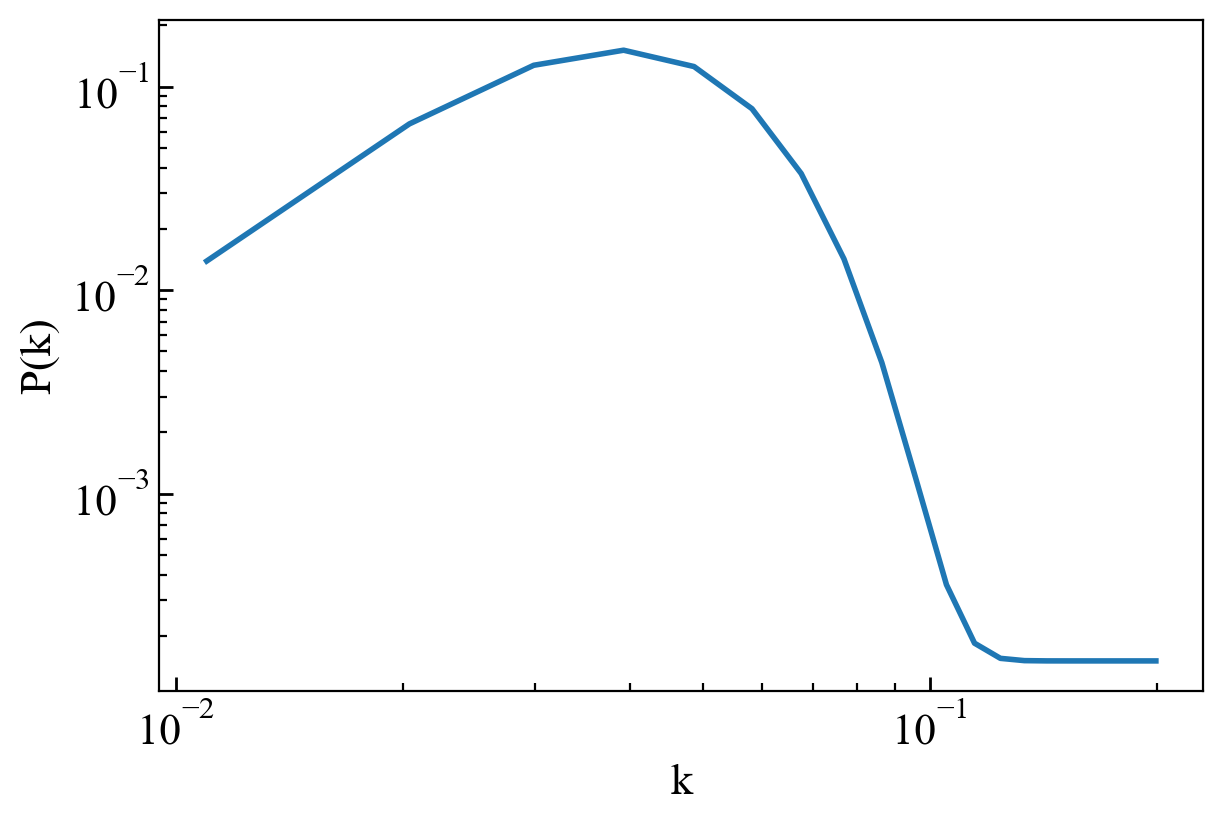

In [4]:
plt.figure()
plt.loglog(mesh.k_ctrs, PK(mesh.k_ctrs, theta), label='Power Spectrum')  
plt.xlabel('k') 
plt.ylabel('P(k)')

In [5]:
Nmocks = 500
#white noise used to generate the field
keys = split(PRNGKey(2),Nmocks)
noise = jnp.array([grid.generate_hermitian_noise(x) for x in keys])

# Defining main functions 

In [6]:
#gaussian and zeldovich field generators
gen = GaussianFieldGenerator1D(grid, PK)
zel = Zeldovich1D(gen, mesh, scheme = 'tsc')

We start by taking a look at the typical displacements we get for this setup:

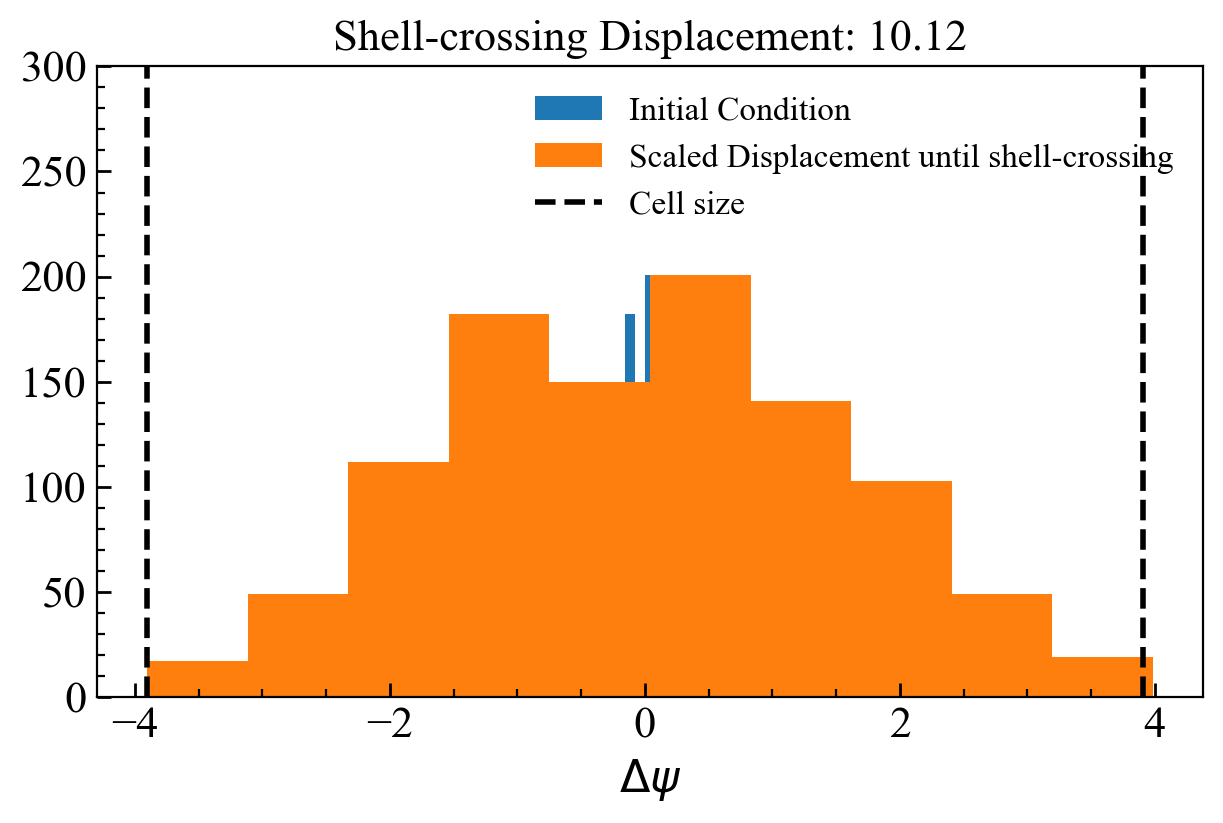

In [7]:
psi_q = zel.compute_displacement(theta, noise[0])
dif_psi_q = jnp.diff(psi_q)
min_dpsi = jnp.min(dif_psi_q)
D_sc = - grid.H[0] / min_dpsi  

plt.hist(dif_psi_q, label = 'Initial Condition')
plt.hist(D_sc*dif_psi_q, label = 'Scaled Displacement until shell-crossing') 
plt.vlines(grid.H[0], 0, 1000, color='black', label='Cell size', ls = '--')
plt.vlines(-grid.H[0], 0, 1000, color='black', ls = '--')
plt.ylim((0,300))
plt.legend()
plt.xlabel(r'$\Delta \psi$')
plt.title('Shell-crossing Displacement: {:.2f}'.format(D_sc));

/Users/s2223060/Desktop/diff_weighted_fields/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/s2223060/Desktop/diff_weighted_fields/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


[Text(0, -0.1, '-0.10'),
 Text(0, 0.0, '0.00'),
 Text(0, 0.10000000000000003, '0.10'),
 Text(0, 0.2, '0.20'),
 Text(0, 0.3, '0.30')]

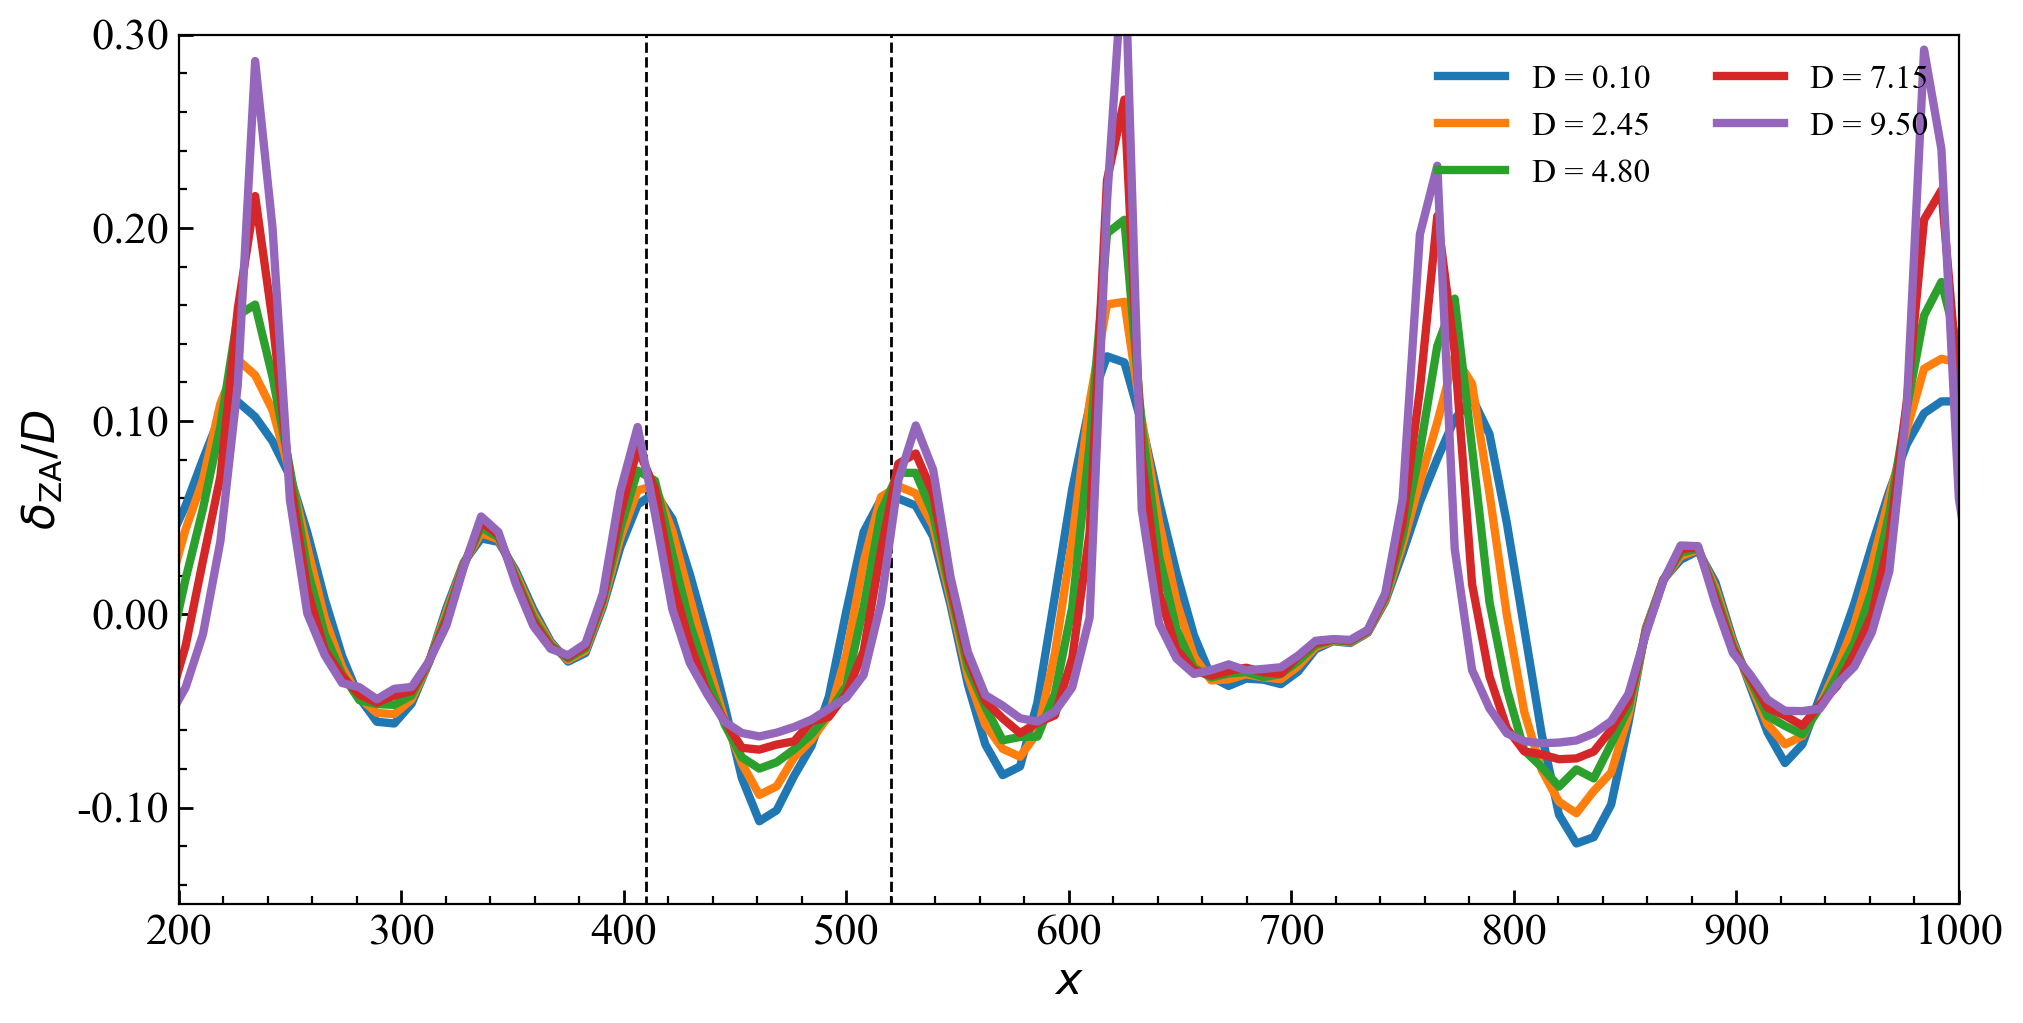

In [8]:
plt.figure(figsize=(10, 5))
plt.vlines(410, -1, 1, colors='black', ls='--', lw=1)
plt.vlines(520, -1, 1, colors='black', ls='--', lw=1)

for d in jnp.linspace(0.1, 9.5, 5):
    zel = zel.make_realization(d, theta, noise[0])
    deltaq = jnp.fft.ifft(zel.delta_k ) * grid.norm_ifft
    plt.plot(zel.grid.q, deltaq / d, label=f'D = {d:.2f}', lw=3)
    plt.xlim((200, 1000))

plt.xlabel(r'$x$')
plt.legend(loc='upper right', ncols=2)
plt.ylabel(r'$\delta_{\rm ZA}/D$')
plt.ylim((-0.15, 0.3))

# Remove the first tick label on the y-axis
yticks = plt.gca().get_yticks()
plt.gca().set_yticks(yticks[1:])
plt.gca().set_yticklabels([f'{tick:.2f}' for tick in yticks[1:]])

#plt.savefig('zeldovich_evol.pdf', bbox_inches='tight')

We are interested in measuring the information content in the power spectrum of the transformed field:
$$
\rho_{\rm M}(x) = \bar{\rho}(1 + \delta(x))\left[C_0 +  C_1 \frac{\delta_R(x)}{\sigma_{\delta_R}} + C_2 \frac{\delta_R(x)^2}{\sigma_{\delta_R^2}} + C_3 \frac{\delta_R(x)^3}{\sigma_{\delta_R^3}} \right]\;,
$$
with:
$$
\delta_{\rm M}(x) = \frac{\rho_{\rm M}(x)}{\bar{\rho}_{\rm M}}-1\;.
$$

In [9]:
def compute_pk_single(theta,D,C,noise):
    zel = Zeldovich1D(gen, mesh, scheme = 'tsc')
    zel.make_realization(D,theta,noise)
    zel.ComputeBasis(R_smooth)
    f1 = zel.WeightedChild(C)
    return PowerSpectrum(f1,f1,compensate=True)

compute_pk = jax.vmap(compute_pk_single, in_axes=(None, None, None, 0))

Text(0, 0.5, '$P(k)/D^2$')

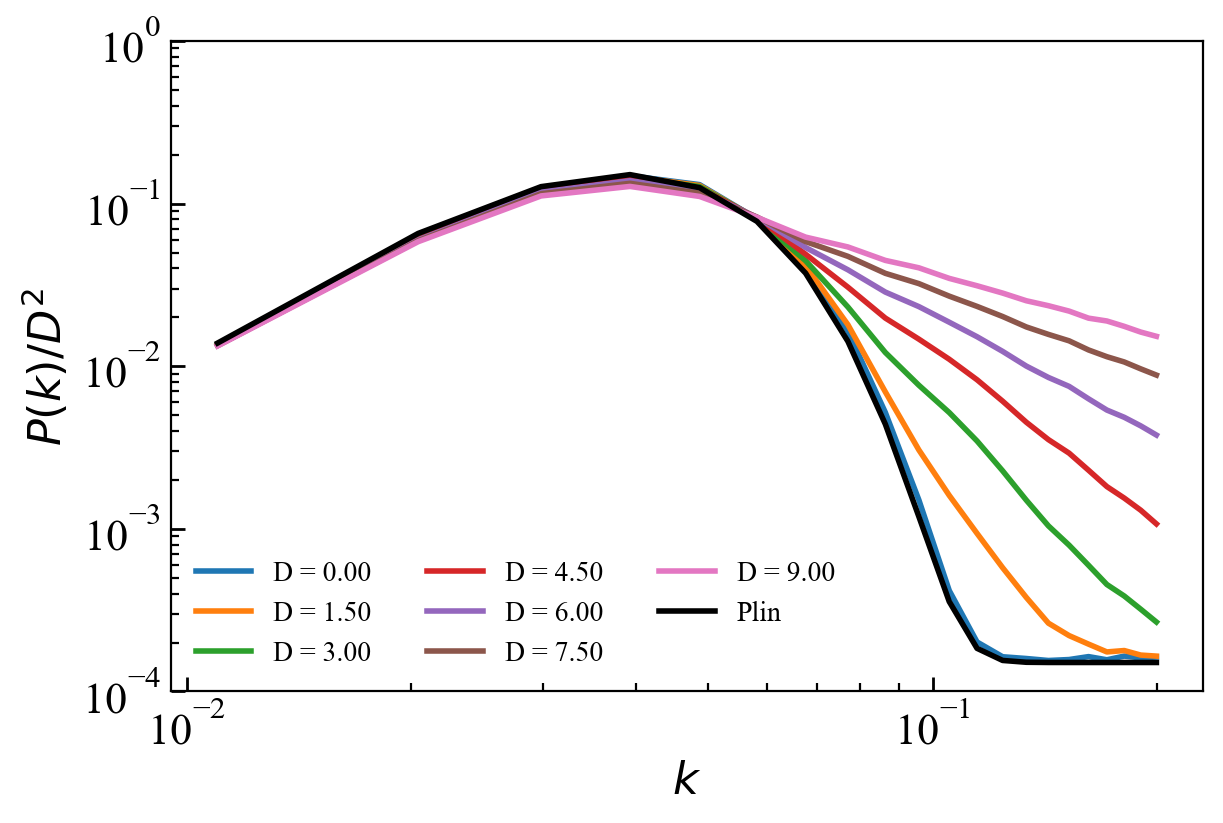

In [10]:
covs = []
C = jnp.array([1,0,0,0])
for d in jnp.linspace(0.001,9, 7):
    pks_ZEL = compute_pk(theta,d,C,noise)
    covs.append(jnp.cov(pks_ZEL.T))
    k_ctrs = mesh.k_ctrs
    plt.loglog(k_ctrs,jnp.mean(pks_ZEL,axis = 0)/d**2,label = 'D = {:.2f}'.format(d))
plt.plot(k_ctrs,PK(k_ctrs,theta),label = 'Plin', color = 'black', lw = 2)
plt.ylim((1e-4,1))
plt.legend(ncols = 3,fontsize = 10)
plt.xlabel('$k$')
plt.ylabel('$P(k)/D^2$')
#plt.savefig('zeldovich_pk.pdf', bbox_inches='tight')

Text(0, 0.5, '$P(k)/D^2$')

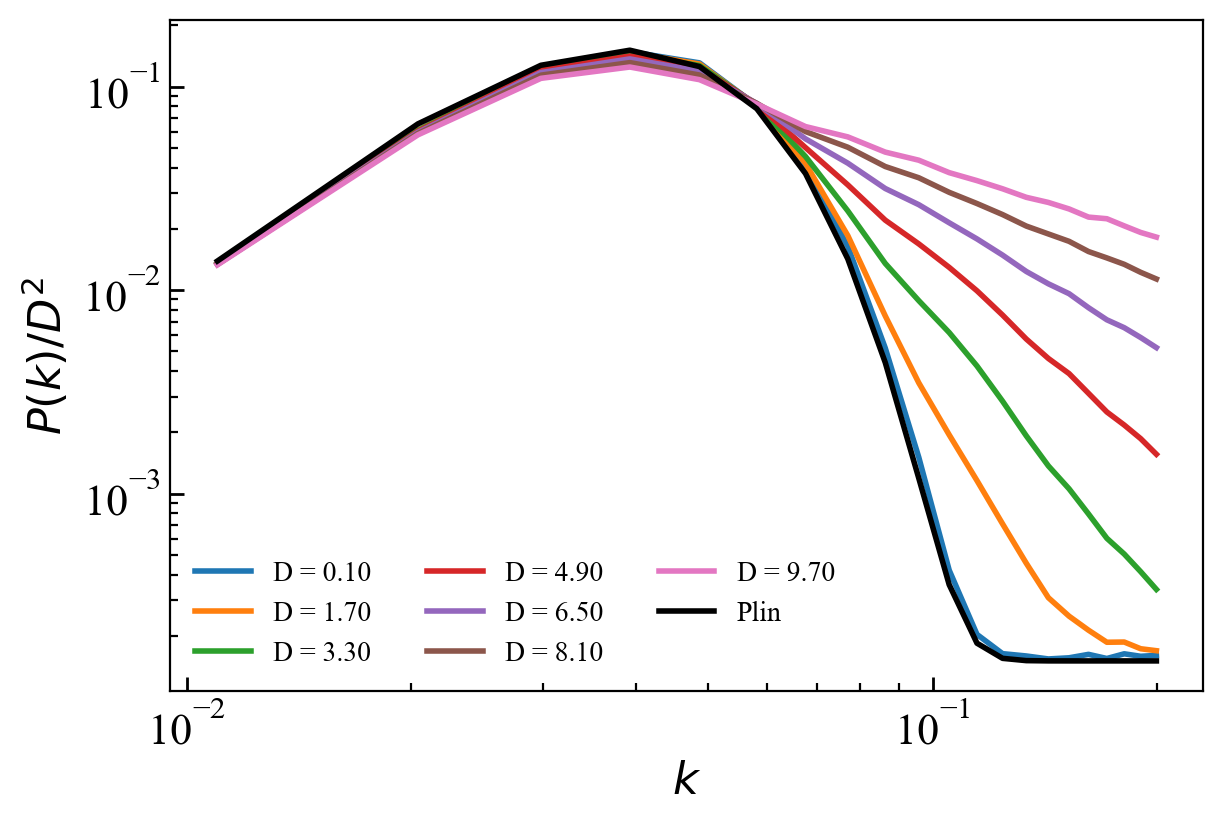

In [11]:
covs = []
C = jnp.array([1,0,0,0])
for d in jnp.linspace(0.1, 9.7, 7):
    pks_ZEL = compute_pk(theta,d,C,noise)
    covs.append(jnp.cov(pks_ZEL.T))
    k_ctrs = mesh.k_ctrs
    plt.plot(k_ctrs,jnp.mean(pks_ZEL,axis = 0)/d**2,label = 'D = {:.2f}'.format(d))
plt.loglog(k_ctrs,PK(k_ctrs,theta),label = 'Plin', color = 'black', lw = 2)
plt.legend(ncols = 3,fontsize = 10)
plt.xlabel('$k$')
plt.ylabel('$P(k)/D^2$')
#plt.savefig('zeldovich_pk.pdf', bbox_inches='tight')

In [12]:
Ki, Kj = jnp.meshgrid(mesh.k_ctrs,mesh.k_ctrs, indexing='ij')

/var/folders/f8/984tm4nj4h53x1yjrnpd76bw0000gn/T/ipykernel_58966/2025278789.py:6: UserWarning: The following kwargs were not used by contour: 'interpolation'
  im = ax.contourf(Ki, Kj, corr, cmap='coolwarm', interpolation='none', levels=levels)


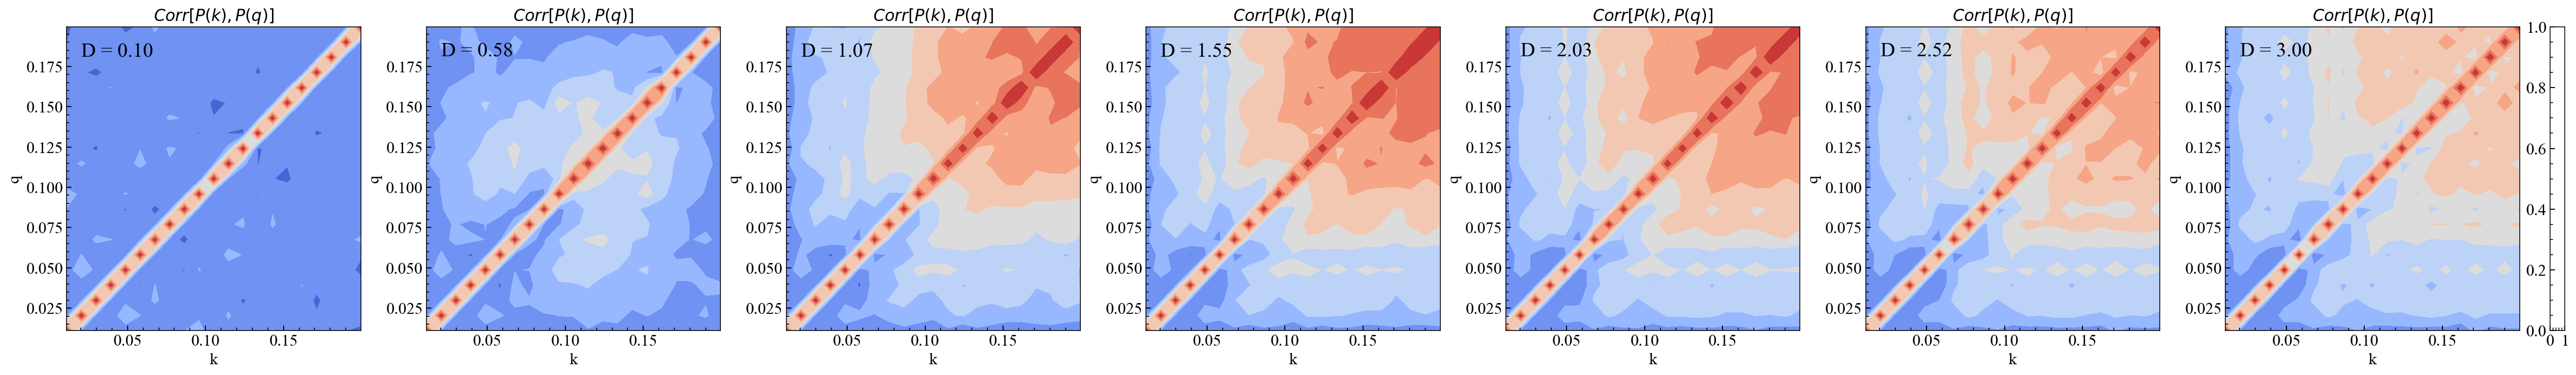

In [13]:
fig, axes = plt.subplots(1, len(covs) + 1, figsize=(5*len(covs), 5), gridspec_kw={'width_ratios': [1] * len(covs) + [0.05]}, dpi=150, constrained_layout=True)    
levels = jnp.linspace(-0.2, 1, 10)
D_values = jnp.linspace(0.1, 3, len(covs))  # Adjusted to match the number of covs
for i, (ax, cov) in enumerate(zip(axes[:-1], covs)):
    corr = covariance_to_correlation(cov)
    im = ax.contourf(Ki, Kj, corr, cmap='coolwarm', interpolation='none', levels=levels)
    ax.set_title(f'$Corr[P(k),P(q)]$')
    ax.set_xlabel('k')
    ax.set_ylabel('q')
    # Annotate D in the upper left region
    ax.text(0.05, 0.95, f'D = {D_values[i]:.2f}', transform=ax.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='left')

# Add a single colorbar on the right
#fig.colorbar(im, cax=axes[-1], label='Correlation')
#plt.savefig('zeldovich_corr.pdf', bbox_inches='tight')
#plt.show()

In [14]:
D = 5.
R_mark = 0*mesh.H[0]#0.5*R_pk  # smoothing radius
R_mark = float(R_mark * mesh.H[0])
zel = Zeldovich1D(gen, mesh, scheme = 'tsc')
zel.make_realization(D,theta,noise[0])
zel.ComputeBasis(R_mark)

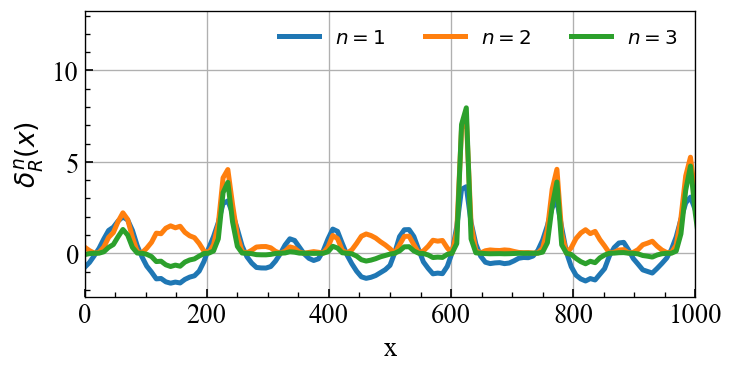

In [15]:
plt.figure(figsize = (6,3), dpi = 120)
plt.plot(zel.grid.q,zel.m_array[1]/jnp.std(zel.m_array[1]), lw = 3, label = r'$n = 1$')
plt.plot(zel.grid.q,zel.m_array[2]/jnp.std(zel.m_array[2]), lw = 3, label = r'$n = 2$')
plt.plot(zel.grid.q,zel.m_array[3]/jnp.std(zel.m_array[3]), lw = 3, label = r'$n = 3$')
plt.xlim((0,1000))
plt.grid()
#plt.ylim((-1,1))
plt.xlabel('x')
plt.ylabel(r"$\delta^n_{R}(x)$")
plt.legend(ncols = 4)

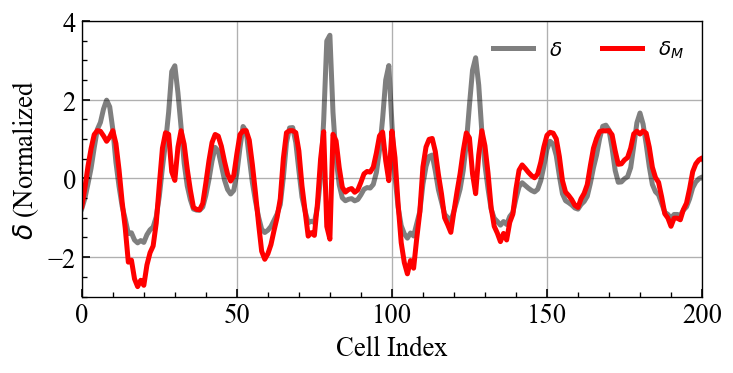

In [16]:
C = jnp.array([2,-0.27/jnp.std(zel.m_array[1]),0.0,0])
marked = zel.WeightedChild(C)
plt.figure(figsize = (6,3), dpi = 120)
plt.plot(zel.delta/jnp.std(zel.delta), color = 'black', lw = 3, alpha = 0.5, label = r'$\delta$')
plt.plot(marked.delta/jnp.std(marked.delta), color = 'red', lw = 3, alpha = 1, label = r'$\delta_M$')
plt.xlim((0,200))
plt.grid()
plt.ylim((-3,4))
plt.xlabel('Cell Index')
plt.ylabel('$\delta$ (Normalized ')
plt.legend(ncols = 4)

Now, let us study how the Fisher information varies with D:

In [17]:
def compute_pk(theta,D,C,noise):
    zel = Zeldovich1D(gen, mesh, scheme = 'tsc')
    zel = zel.make_realization(D, theta, noise)
    zel.ComputeBasis(R_mark)
    f1 = zel.WeightedChild(C)
    return PowerSpectrum(f1,f1, compensate=True)

batched_over_noise = jax.jit(jax.vmap(compute_pk, in_axes=(None, None, None, 0)))
mean_pk = lambda theta, D, C: jnp.mean(batched_over_noise(theta, D, C, noise), axis=0)
dPk_func = jax.jit(jax.jacfwd(mean_pk))

@jax.jit
def compute_inv_cov(x):
    x = x - jnp.mean(x, axis=0)
    cov = (x.T @ x) / (x.shape[0] - 1)
    p_eff = jax.numpy.linalg.matrix_rank(cov)
    hartlap = (Nmocks - p_eff - 2.0) / (Nmocks - 1.0)
    return jnp.linalg.inv(cov)*hartlap

F = []

D = jnp.linspace(0.01, 4, 50)
for d in tqdm(D):
    pks = batched_over_noise(theta, d, C, noise)
    inv_cov = compute_inv_cov(pks)
    dPk = dPk_func(theta, d, C)
    F.append(dPk.T @ inv_cov @ dPk)
F = jnp.array(F)

100%|██████████| 50/50 [00:04<00:00, 10.66it/s]


Text(0.5, 0, 'Growth Factor (D)')

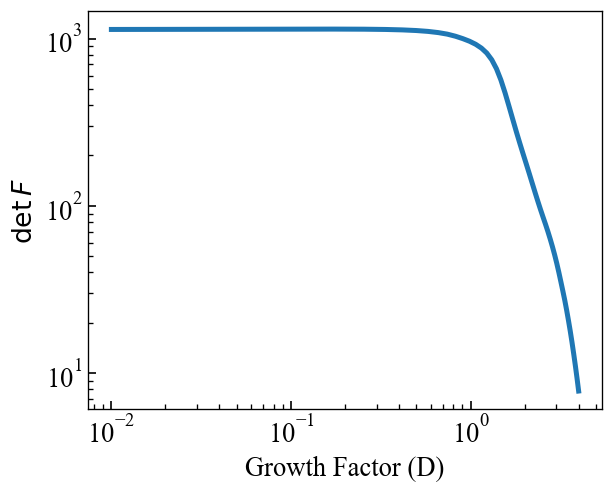

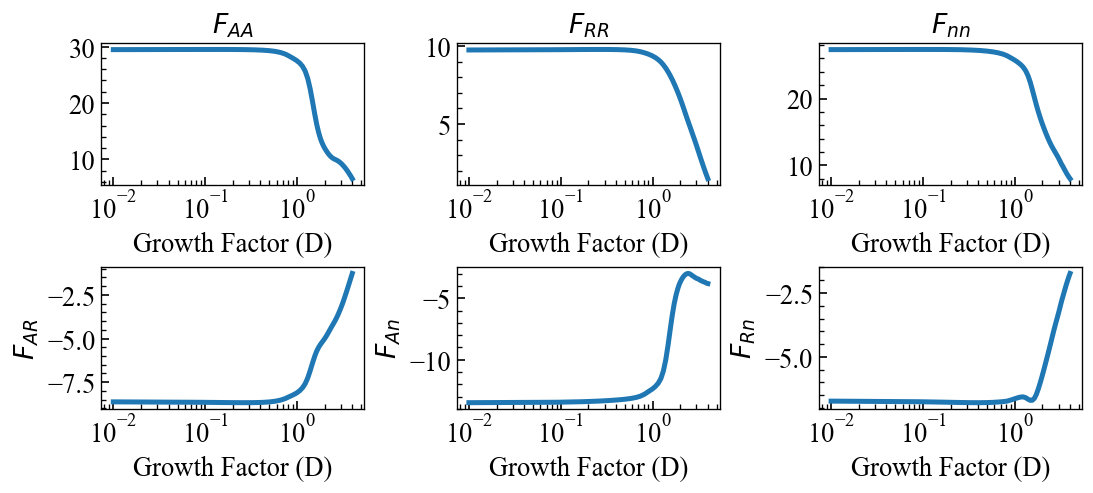

In [18]:
detF = jnp.linalg.det(F)
plt.figure(figsize = (5,4),dpi = 120)
plt.loglog(D, detF, lw = 3)
plt.xlabel('Growth Factor (D)')
plt.ylabel('$\det F$')
plt.savefig('overall_detF.pdf', bbox_inches='tight')
fig, ax = plt.subplots(2, 3, figsize=(9, 4), constrained_layout=True, dpi=120)

# Diagonal elements of the Fisher matrix
ax[0, 0].semilogx(D, F[:, 0, 0], lw = 3)
ax[0, 0].set_title('$F_{AA}$')
ax[0, 0].set_xlabel('Growth Factor (D)')

ax[0, 1].semilogx(D, F[:, 1, 1], lw = 3)
ax[0, 1].set_title('$F_{RR}$')
ax[0, 1].set_xlabel('Growth Factor (D)')

ax[0, 2].semilogx(D, F[:, 2, 2], lw = 3)
ax[0, 2].set_title('$F_{nn}$')
ax[0, 2].set_xlabel('Growth Factor (D)')

# Off-diagonal elements of the Fisher matrix
ax[1, 0].semilogx(D, F[:, 0, 1], lw = 3)
ax[1, 0].set_ylabel('$F_{AR}$')
ax[1, 0].set_xlabel('Growth Factor (D)')

ax[1, 1].semilogx(D, F[:, 0, 2], lw = 3)
ax[1, 1].set_ylabel('$F_{An}$')
ax[1, 1].set_xlabel('Growth Factor (D)')

ax[1, 2].semilogx(D, F[:, 1, 2], lw = 3)
ax[1, 2].set_ylabel('$F_{Rn}$')
ax[1, 2].set_xlabel('Growth Factor (D)')
#plt.savefig('fisher_matrix_elements.pdf', bbox_inches='tight')

Now, let us study how the information in the auto power spectrum changes regarding each trasnformation direction. First, we generate a batch of realizations and estimate the typical std:

In [66]:
def get_single_m(theta, D, R_mark, single_noise):
    zel = Zeldovich1D(gen, mesh, scheme='tsc')
    zel.make_realization(D, theta, single_noise)
    zel.ComputeBasis(R_mark)
    return zel.m_array

get_m = jax.jit(lambda theta, D, R_mark: jnp.concatenate(
    [jnp.array([1]), jnp.mean(
        jnp.std(jax.vmap(get_single_m, in_axes=(None, None, None, 0))(theta, D, R_mark, noise), axis=-1), axis=0
    )[1:]]
))

In [71]:
def compute_pk(theta,D,C,R_mark):
        m_norm = jax.lax.stop_gradient(get_m(theta, D, R_mark))
        pk_batch = zel.make_realization_batch(D,theta,R_mark,C/m_norm,noise)
        return pk_batch

jac_pk = jax.jacfwd(compute_pk, argnums=0)

def compute_inv_cov(x):
    x = x - jnp.mean(x, axis=0)
    cov = (x.T @ x) / (x.shape[0] - 1)
    p_eff = jax.numpy.linalg.matrix_rank(cov)
    hartlap = (Nmocks - p_eff - 2.0) / (Nmocks - 1.0)
    return jnp.linalg.inv(cov)*hartlap

compute_inv_cov_batch = jax.vmap(compute_inv_cov, in_axes=0)

def compute_cov(x):
    x = x - jnp.mean(x, axis=0)
    return jnp.linalg.inv((x.T @ x) / (x.shape[0] - 1))
compute_cov_batch = jax.vmap(compute_cov, in_axes=0)

def compute_F_batch(theta,D,C,R_mark):
    P = compute_pk(theta, D, C, R_mark)
    inv_cov = compute_inv_cov_batch(P)
    J = jac_pk(theta, D, C, R_mark)
    J = jnp.mean(J, axis=1)
    F = jnp.einsum('nij, nip, njq->npq', inv_cov, J, J)
    return F

compute_F_batch = jax.jit(compute_F_batch)

In [76]:
Nx = 100

c1_vec = jnp.logspace(-3, jnp.log10(1), Nx)
c2_vec = jnp.logspace(-3, jnp.log10(1), Nx)
c3_vec = jnp.logspace(-3, jnp.log10(1), Nx)

ones_flat = jnp.ones_like(c1_vec)
zeros_flat = jnp.zeros_like(c1_vec)

C1_pos_array = jnp.stack([2*ones_flat, c1_vec     , zeros_flat, zeros_flat], axis=1)
C1_neg_array = jnp.stack([2*ones_flat, -c1_vec     , zeros_flat, zeros_flat], axis=1)

C2_pos_array = jnp.stack([2*ones_flat, zeros_flat,  c2_vec     , zeros_flat], axis=1)
C2_neg_array = jnp.stack([2*ones_flat, zeros_flat,  -c2_vec     , zeros_flat], axis=1)

C3_pos_array = jnp.stack([2*ones_flat, zeros_flat, zeros_flat, c3_vec], axis=1)
C3_neg_array = jnp.stack([2*ones_flat, zeros_flat, zeros_flat ,-c3_vec], axis=1)

batch_size = 10
steps = Nx// batch_size

In [77]:
#warmup
R_mark = 0.0
D = 7.0
_ = compute_F_batch(theta,D,C1_pos_array[0:batch_size],R_mark).block_until_ready()

In [78]:
d_stack_F1 = []
d_stack_F2 = []
d_stack_F3 = []
FAA_F1_stack = []
FAA_F2_stack = []
FAA_F3_stack = []
FRR_F1_stack = []
FRR_F2_stack = []
FRR_F3_stack = []
Fnn_F1_stack = []
Fnn_F2_stack = []
Fnn_F3_stack = []
FAR_F1_stack = []
FAn_F1_stack = []
FRn_F1_stack = []

D_vec = jnp.linspace(0.1,10,100)
R_mark = 0*R_pk  # smoothing radius

for d in D_vec:
    F1_pos = []
    F1_neg = []
    F2_pos = []
    F2_neg = []
    F3_pos = []
    F3_neg = []

    for i in tqdm(range(steps)):
        start = i * batch_size
        end = start + batch_size

        F1_pos.append(compute_F_batch(theta, d, C1_pos_array[start:end], R_mark).block_until_ready())
        F1_neg.append(compute_F_batch(theta, d, C1_neg_array[start:end], R_mark).block_until_ready())

        F2_pos.append(compute_F_batch(theta, d, C2_pos_array[start:end], R_mark).block_until_ready())
        F2_neg.append(compute_F_batch(theta, d, C2_neg_array[start:end], R_mark).block_until_ready())

        F3_pos.append(compute_F_batch(theta, d, C3_pos_array[start:end], R_mark).block_until_ready())
        F3_neg.append(compute_F_batch(theta, d, C3_neg_array[start:end], R_mark).block_until_ready())

    F1_pos = jnp.array(F1_pos)    
    F1_neg = jnp.array(F1_neg)
    F1_pos = F1_pos.reshape((Nx, 3,3))
    F1_neg = F1_neg.reshape((Nx, 3,3))

    F2_pos = jnp.array(F2_pos)
    F2_neg = jnp.array(F2_neg)
    F2_pos = F2_pos.reshape((Nx, 3,3))
    F2_neg = F2_neg.reshape((Nx, 3,3))

    F3_pos = jnp.array(F3_pos)
    F3_neg = jnp.array(F3_neg)
    F3_pos = F3_pos.reshape((Nx, 3,3))
    F3_neg = F3_neg.reshape((Nx, 3,3))

    d_stack_F1.append((jnp.linalg.det(F1_pos), jnp.linalg.det(F1_neg)))
    d_stack_F2.append((jnp.linalg.det(F2_pos), jnp.linalg.det(F2_neg)))
    d_stack_F3.append((jnp.linalg.det(F3_pos), jnp.linalg.det(F3_neg)))
    FAA_F1_stack.append((F1_pos[:, 0, 0], F1_neg[:, 0, 0]))
    FAA_F2_stack.append((F2_pos[:, 0, 0], F2_neg[:, 0, 0]))
    FAA_F3_stack.append((F3_pos[:, 0, 0], F3_neg[:, 0, 0]))
    FRR_F1_stack.append((F1_pos[:, 1, 1], F1_neg[:, 1, 1]))
    FRR_F2_stack.append((F2_pos[:, 1, 1], F2_neg[:, 1, 1]))
    FRR_F3_stack.append((F3_pos[:, 1, 1], F3_neg[:, 1, 1]))
    Fnn_F1_stack.append((F1_pos[:, 2, 2], F1_neg[:, 2, 2]))
    FRn_F1_stack.append((F1_pos[:, 1, 2], F1_neg[:, 1, 2]))
    FAn_F1_stack.append((F1_pos[:, 0, 2], F1_neg[:, 0, 2]))
    FAR_F1_stack.append((F1_pos[:, 0, 1], F1_neg[:, 0, 1]))
    Fnn_F2_stack.append((F2_pos[:, 2, 2], F2_neg[:, 2, 2]))
    Fnn_F3_stack.append((F3_pos[:, 2, 2], F3_neg[:, 2, 2]))

100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


In [79]:
color1=mcp.gen_color(cmap="Reds",n=len(D_vec)+ 2)[2:]
color2=mcp.gen_color(cmap="Blues",n=len(D_vec)+ 2)[2:]
color3=mcp.gen_color(cmap="Greens",n=len(D_vec)+ 2)[2:]

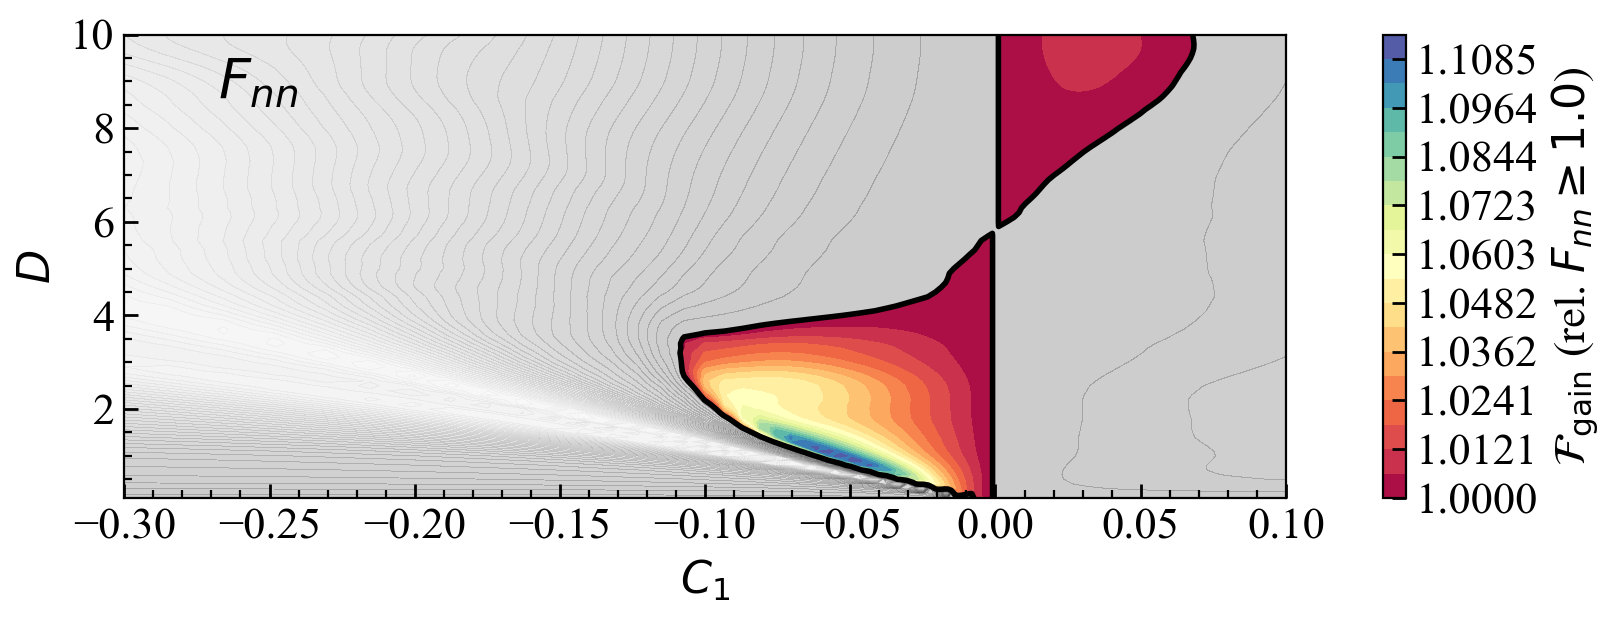

In [89]:
import numpy as np

# First convert everything to NumPy:
M = len(d_stack_F1)
Nx = d_stack_F1[0][0].shape[0]

rel_pos = np.zeros((M, Nx))
rel_neg = np.zeros((M, Nx))

for i, (det_pos_jax, det_neg_jax) in enumerate(Fnn_F1_stack):
    det_pos = np.array(det_pos_jax)
    det_neg = np.array(det_neg_jax)
    # normalize by the unmarked (C=0) case, which is det_*[0]
    rel_pos[i, :] = det_pos / det_pos[0]
    rel_neg[i, :] = det_neg / det_neg[0]

# 1) Full C1 axis
c1_total = np.concatenate([-c1_vec[::-1], c1_vec])

# 3) Build meshgrid for plotting contours
C1_MESH, D_MESH = np.meshgrid(c1_total, D_vec, indexing='xy')


# 2) Combine negative and positive into one 2D array
rel_mesh = np.concatenate([rel_neg[:, ::-1], rel_pos], axis=1)  # shape (M, 2N)

levels_below = jnp.linspace(0.0, 1, 50)
levels_above = jnp.linspace(1, jnp.max(rel_neg), 20)

fig, ax = plt.subplots(figsize = (8,3),constrained_layout=True)

contour1 = plt.contourf(C1_MESH, D_MESH, rel_mesh, cmap='Greys', alpha=0.2, levels=levels_below)
contour2 = plt.contourf(C1_MESH, D_MESH, rel_mesh, cmap='Spectral', alpha=1, levels=levels_above)
_ = plt.contour(C1_MESH, D_MESH, rel_mesh, colors='black', alpha=1, levels=[1])
# _ = plt.contour(C1_ST,C2_ST,detFisher_normed, levels2, cmap = 'Reds',alpha = 1,levels = [1.,1.3])
# cbar1 = plt.colorbar(contour1, label='$1.0 \leq $rel. $\det F < 1$ ')
cbar2 = plt.colorbar(contour2, label=r'$\mathcal{F}_{\rm gain}$ (rel. $F_{nn} \geq 1.0$)')
plt.xlabel('$C_1$')
plt.ylabel('$D$')
plt.xlim((-0.3, 0.1))
#plt.ylim((1, 10))

# Add text in the upper right corner
ax.text(0.15, 0.95, r'$F_{nn}$', transform=ax.transAxes, fontsize=20, verticalalignment='top', horizontalalignment='right', color = 'black')

plt.savefig('FGAIN_zeldovich_C1_PARAM_n.pdf')

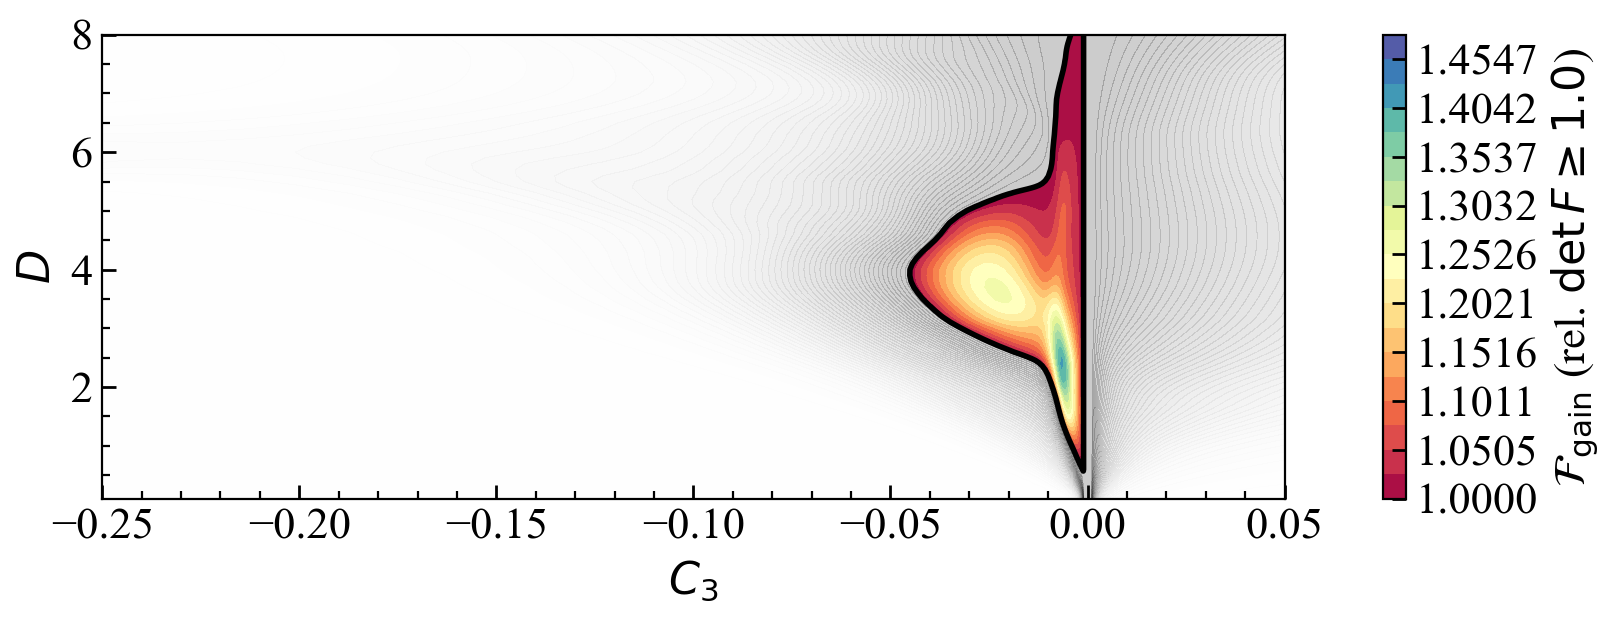

In [115]:
import numpy as np

# First convert everything to NumPy:
M = len(d_stack_F2)
Nx = d_stack_F1[0][0].shape[0]

rel_pos = np.zeros((M, Nx))
rel_neg = np.zeros((M, Nx))

for i, (det_pos_jax, det_neg_jax) in enumerate(d_stack_F3):
    det_pos = np.array(det_pos_jax)
    det_neg = np.array(det_neg_jax)
    # normalize by the unmarked (C=0) case, which is det_*[0]
    rel_pos[i, :] = det_pos / det_pos[0]
    rel_neg[i, :] = det_neg / det_neg[0]

# 1) Full C1 axis
c1_total = np.concatenate([-c1_vec[::-1], c1_vec])

# 3) Build meshgrid for plotting contours
C1_MESH, D_MESH = np.meshgrid(c1_total, D_vec, indexing='xy')

# 2) Combine negative and positive into one 2D array
rel_mesh = np.concatenate([rel_neg[:, ::-1], rel_pos], axis=1)  # shape (M, 2N)

levels_below = jnp.linspace(0.0, 1., 50)
levels_above = jnp.linspace(1., 1.48, 20)

fig, ax = plt.subplots(figsize = (8,3),constrained_layout=True)

contour1 = plt.contourf(C1_MESH, D_MESH, rel_mesh, cmap='Greys', alpha = 0.2, levels = levels_below)
contour2 = plt.contourf(C1_MESH, D_MESH, rel_mesh, cmap='Spectral', alpha = 1, levels = levels_above)
_ = plt.contour(C1_MESH, D_MESH, rel_mesh, colors='black', alpha = 1, levels = [1])
#_ = plt.contour(C1_ST,C2_ST,detFisher_normed, levels2, cmap = 'Reds',alpha = 1,levels = [1.,1.3])
#cbar1 = plt.colorbar(contour1, label='$1.0 \leq $rel. $\det F < 1$ ')
cbar2 = plt.colorbar(contour2, label=r'$\mathcal{F}_{\rm gain}$ (rel. $\det F \geq 1.0$)')
plt.xlabel('$C_3$')
plt.ylabel('$D$')
plt.xlim((-0.25,0.05))
plt.ylim((0.1,8))
plt.savefig('FGAIN_zeldovich_C3.pdf')

In [ ]:
# 1) Full C1 axis
c1_total = np.concatenate([-c1_vec[::-1], c1_vec])

# 3) Build meshgrid for plotting contours
C1_MESH, D_MESH = np.meshgrid(c1_total, D_vec, indexing='xy')


# 2) Combine negative and positive into one 2D array
rel_mesh = np.concatenate([rel_neg[:, ::-1], rel_pos], axis=1)  # shape (M, 2N)

levels_below = jnp.linspace(0.0, 1, 50)
levels_above = jnp.linspace(1, 1.8, 20)

fig, ax = plt.subplots(constrained_layout=True)

contour1 = plt.contourf(C1_MESH, D_MESH, rel_mesh, cmap='Greys', alpha = 0.2, levels = levels_below)
contour2 = plt.contourf(C1_MESH, D_MESH, rel_mesh, cmap='Spectral', alpha = 1, levels = levels_above)
_ = plt.contour(C1_MESH, D_MESH, rel_mesh, colors='black', alpha = 1, levels = [1])
#_ = plt.contour(C1_ST,C2_ST,detFisher_normed, levels2, cmap = 'Reds',alpha = 1,levels = [1.,1.3])
#cbar1 = plt.colorbar(contour1, label='$1.0 \leq $rel. $\det F < 1$ ')
cbar2 = plt.colorbar(contour2, label=r'$\mathcal{F}_{\rm gain}$ (rel. $\det F \geq 1.0$)')
plt.xlabel('$C_2$')
plt.ylabel('$D$')
plt.xlim((-0.2,0.2))
plt.ylim((1,10))
#plt.savefig('FGAIN_zeldovich_C2.pdf')

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(12, 12), dpi=100, constrained_layout=True)

for i in range(0, len(D_vec)):
    # detF
    ax[0, 0].semilogx(c1_vec, d_stack_F1[i][0] / d_stack_F1[i][0][0], lw=2, ls='-', color=color1[i], label=f'D = {D_vec[i]:.2f}')
    ax[0, 0].semilogx(c1_vec, d_stack_F1[i][1] / d_stack_F1[i][1][0], lw=2, ls='--', color=color1[i])
    ax[0, 1].semilogx(c2_vec, d_stack_F2[i][0] / d_stack_F2[i][0][0], lw=2, ls='-', color=color2[i], label=f'D = {D_vec[i]:.2f}')
    ax[0, 1].semilogx(c2_vec, d_stack_F2[i][1] / d_stack_F2[i][1][0], lw=2, ls='--', color=color2[i])
    ax[0, 2].semilogx(c3_vec, d_stack_F3[i][0] / d_stack_F3[i][0][0], lw=2, ls='-', color=color3[i], label=f'D = {D_vec[i]:.2f}')
    ax[0, 2].semilogx(c3_vec, d_stack_F3[i][1] / d_stack_F3[i][1][0], lw=2, ls='--', color=color3[i])

    # FAA
    ax[1, 0].semilogx(c1_vec, FAA_F1_stack[i][0] / FAA_F1_stack[i][0][0], lw=2, ls='-', color=color1[i], label=f'D = {D_vec[i]:.2f}')
    ax[1, 0].semilogx(c1_vec, FAA_F1_stack[i][1] / FAA_F1_stack[i][1][0], lw=2, ls='--', color=color1[i])
    ax[1, 1].semilogx(c2_vec, FAA_F2_stack[i][0] / FAA_F2_stack[i][0][0], lw=2, ls='-', color=color2[i], label=f'D = {D_vec[i]:.2f}')
    ax[1, 1].semilogx(c2_vec, FAA_F2_stack[i][1] / FAA_F2_stack[i][1][0], lw=2, ls='--', color=color2[i])
    ax[1, 2].semilogx(c3_vec, FAA_F3_stack[i][0] / FAA_F3_stack[i][0][0], lw=2, ls='-', color=color3[i], label=f'D = {D_vec[i]:.2f}')
    ax[1, 2].semilogx(c3_vec, FAA_F3_stack[i][1] / FAA_F3_stack[i][1][0], lw=2, ls='--', color=color3[i])

    # FRR
    ax[2, 0].semilogx(c1_vec, FRR_F1_stack[i][0] / FRR_F1_stack[i][0][0], lw=2, ls='-', color=color1[i], label=f'D = {D_vec[i]:.2f}')
    ax[2, 0].semilogx(c1_vec, FRR_F1_stack[i][1] / FRR_F1_stack[i][1][0], lw=2, ls='--', color=color1[i])
    ax[2, 1].semilogx(c2_vec, FRR_F2_stack[i][0] / FRR_F2_stack[i][0][0], lw=2, ls='-', color=color2[i], label=f'D = {D_vec[i]:.2f}')
    ax[2, 1].semilogx(c2_vec, FRR_F2_stack[i][1] / FRR_F2_stack[i][1][0], lw=2, ls='--', color=color2[i])
    ax[2, 2].semilogx(c3_vec, FRR_F3_stack[i][0] / FRR_F3_stack[i][0][0], lw=2, ls='-', color=color3[i], label=f'D = {D_vec[i]:.2f}')
    ax[2, 2].semilogx(c3_vec, FRR_F3_stack[i][1] / FRR_F3_stack[i][1][0], lw=2, ls='--', color=color3[i])

    # Fnn
    ax[3, 0].semilogx(c1_vec, Fnn_F1_stack[i][0] / Fnn_F1_stack[i][0][0], lw=2, ls='-', color=color1[i], label=f'D = {D_vec[i]:.2f}')
    ax[3, 0].semilogx(c1_vec, Fnn_F1_stack[i][1] / Fnn_F1_stack[i][1][0], lw=2, ls='--', color=color1[i])
    ax[3, 1].semilogx(c2_vec, Fnn_F2_stack[i][0] / Fnn_F2_stack[i][0][0], lw=2, ls='-', color=color2[i], label=f'D = {D_vec[i]:.2f}')
    ax[3, 1].semilogx(c2_vec, Fnn_F2_stack[i][1] / Fnn_F2_stack[i][1][0], lw=2, ls='--', color=color2[i])
    ax[3, 2].semilogx(c3_vec, Fnn_F3_stack[i][0] / Fnn_F3_stack[i][0][0], lw=2, ls='-', color=color3[i], label=f'D = {D_vec[i]:.2f}')
    ax[3, 2].semilogx(c3_vec, Fnn_F3_stack[i][1] / Fnn_F3_stack[i][1][0], lw=2, ls='--', color=color3[i])

for i in range(4):
    for j in range(3):
        ax[i, j].set_xlabel(f'C{j + 1}')
        ax[i, j].set_ylabel('F')
        ax[i, j].grid()
        ax[i, j].legend()
        ax[i,j].set_ylim((0,3))
        if j ==2:
            ax[i,j].set_xlim((1e-3,0.2))
for x in ax[0,:]:
    x.text(0.05, 0.9, 'detF',
            transform=x.transAxes,
            fontsize=15,
            verticalalignment='top',
            horizontalalignment='left')
    
for x in ax[1,:]:
    x.text(0.05, 0.9, 'FAA',
            transform=x.transAxes,
            fontsize=15,
            verticalalignment='top',
            horizontalalignment='left')
    
for x in ax[2,:]:
    x.text(0.05, 0.9, 'FRR',
            transform=x.transAxes,
            fontsize=15,
            verticalalignment='top',
            horizontalalignment='left')
    

for x in ax[3,:]:
    x.text(0.05, 0.9, 'Fnn',
            transform=x.transAxes,
            fontsize=15,
            verticalalignment='top',
            horizontalalignment='left')


In [150]:
bestC3 = C3_neg_array[jnp.argmax(d_stack_F3[0][1][:-10])]
bestC2 = C2_neg_array[jnp.argmax(d_stack_F2[0][1][:-1])]
bestC1 = C1_neg_array[jnp.argmax(d_stack_F1[0][1])]

In [ ]:
bestC1

In [ ]:
D_vec[0]

In [ ]:
D = 1.5
m_norm = jax.lax.stop_gradient(get_m(theta, D, R_mark))
R_mark = 0*mesh.H[0]#0.5*R_pk  # smoothing radius
R_mark = float(R_mark * mesh.H[0])
zel = Zeldovich1D(gen, mesh, scheme = 'tsc')
zel.make_realization(D,theta,noise[0])
zel.ComputeBasis(R_mark)
f1 = zel.WeightedChild(bestC1/m_norm)
f3 = zel.WeightedChild(bestC3/m_norm)
f2 = zel.WeightedChild(bestC2/m_norm)

plt.plot(zel.grid.q,zel.delta)
plt.plot(zel.grid.q,f1.delta)
plt.plot(zel.grid.q,f3.delta)
plt.plot(zel.grid.q,f2.delta)
plt.xlim((900,2000))

In [ ]:
import seaborn as sns

sns.kdeplot(f1.delta, label='Transformed Delta (f1)', fill=True, alpha=0.5)
sns.kdeplot(f2.delta, label='Transformed Delta (f2)', fill=True, alpha=0.5)
sns.kdeplot(f3.delta, label='Transformed Delta (f3)', fill=True, alpha=0.5)
sns.kdeplot(zel.delta, label='Original Delta', fill=False, alpha=1.0, color = 'red',lw = 1,ls = '--')
plt.xlim((-1, 1.0))
plt.legend()
plt.xlabel(r'$\delta$')
plt.ylabel('$P_{\delta}$')

In [157]:
x_D = jnp.logspace(-1,jnp.log10(6),50)

In [158]:
F1_evol_3 = [jnp.linalg.det(compute_F_batch(theta, d, bestC1[None,:], R_mark)) for d in x_D]
F2_evol_3 = [jnp.linalg.det(compute_F_batch(theta, d, bestC2[None,:], R_mark)) for d in x_D]
F3_evol_3 = [jnp.linalg.det(compute_F_batch(theta, d, bestC3[None,:], R_mark)) for d in x_D]
F0_evol_3 = [jnp.linalg.det(compute_F_batch(theta, d, jnp.array([[1,0,0,0]]), R_mark)) for d in x_D]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=100, constrained_layout=True) 
ax[0].semilogx(x_D, F0_evol_3, label='original', color='black', lw=2)
ax[0].semilogx(x_D, F1_evol_3, label='best C1', color=color1[0])
ax[0].vlines((1.0), 1e-3, 1e3, color='black', ls='--', lw=1, label='Optimization Point')
ax[0].semilogx(x_D, F2_evol_3, label='best C2', color=color2[3])
ax[0].semilogx(x_D, F3_evol_3, label='best C3', color=color3[3])
ax[0].hlines(F0_evol_3[0], 0.1, 6, ls='-', color='gray', label='Information Limit')
ax[0].fill_between(x_D, F0_evol_3[0], 500, color='gray', alpha=0.3)  # Paint the region above the information limit
ax[0].set_ylim((0, 500))
ax[0].set_xlim((0.1, 6))

ax[1].semilogx(x_D, F0_evol_2, color='black', lw=2)
ax[1].semilogx(x_D, F1_evol_2,color=color1[3])
ax[1].vlines((2.0), 1e-3, 1e3, color='black', ls='--', lw=1,)
ax[1].semilogx(x_D, F2_evol_2,color=color2[3])
ax[1].semilogx(x_D, F3_evol_2,color=color3[3])
ax[1].hlines(F0_evol_2[0], 0.1, 6, ls='-', color='gray')
ax[1].fill_between(x_D, F0_evol_1[0], 500, color='gray', alpha=0.3)  # Paint the region above the information limit
ax[1].set_ylim((0, 500))
ax[1].set_xlim((0.1, 6))


ax[2].semilogx(x_D, F0_evol_3, color='black', lw=2)
#ax[2].semilogx(x_D, F1_evol_3, color=color1[3])
#ax[2].vlines((3.0), 1e-3, 1e3, color='black', ls='--', lw=1)
#ax[2].semilogx(x_D, F2_evol_3, color=color2[3])
#ax[2].semilogx(x_D, F3_evol_3,color=color3[3])
#ax[2].hlines(F0_evol_3[0], 0.1, 6, ls='-', color='gray')
#ax[2].fill_between(x_D, F0_evol_3[0], 500, color='gray', alpha=0.3)  # Paint the region above the information limit
#ax[2].set_ylim((0, 500))
#ax[2].set_xlim((0.1, 6))

for i in range(3):
    ax[i].set_xlabel('Growth Factor (D)')
    ax[i].set_ylabel('detF')

# Add a single legend outside the plot on top
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fontsize = 15)

#plt.savefig('zel_detF_evol_bestC.pdf', bbox_inches='tight')


In [ ]:
compute_pk(theta,0.2,bestC2[None,:],0).shape

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import jax.numpy as jnp
from matplotlib import transforms
# … your imports for mcp, compute_pk, compute_cov_batch, mesh, theta, bestC1 …

# prepare colormap
color = mcp.gen_color(cmap="Blues", n=13)[2:]
x_D = jnp.linspace(1, 2, 11)
norm = mpl.colors.Normalize(vmin=x_D.min(), vmax=x_D.max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])

# create figure + axes
fig, ax = plt.subplots(figsize=(8,5), constrained_layout=True)

# plot all your lines onto ax
for i, d in enumerate(x_D):
    pks = compute_pk(theta, d, bestC1[None, :], 0)
    pk = jnp.mean(pks, axis=1)[0]
    cov = compute_cov_batch(pks)[0]
    diag = jnp.diag(cov)
    this_color = 'red' if i == 4 else color[i]
    ax.semilogy(mesh.k_ctrs, pk / jnp.sqrt(diag), label=f"{d:.1f}", 
                color=this_color, lw=2)

# attach the colorbar
cbar = fig.colorbar(sm, ax=ax, label='d')

# --- add red strip on the colorbar ---
d_special = float(x_D[4])           # the special d-value
delta    = float((x_D[1] - x_D[0]) * 0.05)  # half-thickness of the band
# create a transform: x in axes coords [0→1], y in data coords
trans = transforms.blended_transform_factory(cbar.ax.transAxes,
                                             cbar.ax.transData)
# draw a filled band
cbar.ax.fill_betweenx([d_special - delta, d_special + delta],
                      0, 1, transform=trans, color='red', clip_on=False)

# labels, limits, legend
ax.set_ylabel(r'$P(k)/\sigma_{P}(k)$')
ax.set_xlabel(r'$k$')
ax.set_xlim(mesh.k_ctrs[0], mesh.k_ctrs[-1])
#ax.legend(title="d values")
#plt.savefig('zel_pk_bestC1_evol.pdf', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
for i,_d in enumerate(x_D):
    m_norm = jax.lax.stop_gradient(get_m(theta, _d, 0))
    zel = Zeldovich1D(gen, mesh, scheme = 'tsc')
    zel.make_realization(_d,theta,noise[1])
    zel.ComputeBasis(R_mark)
    untransfrormed = zel.delta / jnp.std(zel.delta)
    f1 = zel.WeightedChild(bestC1/m_norm).delta
    std = jnp.std(f1)
    transformed = f1 / _d
    if i==4:
        this_color = 'red'
        filled = True
        alpha = 0.3
    else:
        this_color = color[i]
        filled = False
        alpha = 0.5
    sns.kdeplot(transformed, label='Transformed Delta (f1)', fill=filled, alpha=alpha, color = this_color, lw = 3)    
plt.xlabel(r'$\delta$')
plt.ylabel('$P_{\delta}$')
plt.xlim((-0.05,0.05))
#plt.savefig('zel_kde_bestC1.pdf', bbox_inches='tight')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import jax.numpy as jnp
from matplotlib import transforms
import seaborn as sns

# … your imports for mcp, compute_pk, compute_cov_batch, mesh, theta, bestC1, get_m, gen, noise, Zeldovich1D, R_mark …

# prepare colormap and d‐values
color = mcp.gen_color(cmap="Blues", n=13)[2:]
x_D   = jnp.linspace(1, 2, 11)

# build the ScalarMappable for the colorbar
norm = mpl.colors.Normalize(vmin=x_D.min(), vmax=x_D.max())
sm   = mpl.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])

# make a 1×2 figure
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
ax0, ax1 = axes

# === Left: P(k)/σP(k) plot ===
for i, d in enumerate(x_D):
    pks = compute_pk(theta, d, bestC1[None, :], 0)
    pk  = jnp.mean(pks, axis=1)[0]
    cov = compute_cov_batch(pks)[0]
    diag = jnp.diag(cov)
    this_color = 'red' if i == 4 else color[i]
    ax0.semilogy(mesh.k_ctrs, pk / jnp.sqrt(diag),
                 color=this_color, lw=2, label=f"{d:.1f}")

# add colorbar to ax0
cbar = fig.colorbar(sm, ax=ax0, label='d')

# mark the special d‐value on the colorbar with a red strip
d_special = float(x_D[4])
delta     = float((x_D[1] - x_D[0]) * 0.05)
trans = transforms.blended_transform_factory(cbar.ax.transAxes,
                                             cbar.ax.transData)
cbar.ax.fill_betweenx([d_special - delta, d_special + delta],
                      0, 1, transform=trans, color='red', clip_on=False)

ax0.set_xlabel(r'$k$')
ax0.set_ylabel(r'$P(k)/\sigma_{P}(k)$')
ax0.set_xlim(mesh.k_ctrs[0], mesh.k_ctrs[-1])
ax0.text(
    0.5, 0.95,                            # x, y in axes fraction
    r'$C = \mathrm{bestC1}\ \mathrm{for}\ D=3$',  # the text
    transform=ax0.transAxes,
    fontsize=12,
    color='black',
    fontweight='bold',
    verticalalignment='top',
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)

# ax0.legend(title="d values")  # enable if you want a legend

# === Right: KDE of transformed delta ===
for i, _d in enumerate(x_D):
    m_norm = jax.lax.stop_gradient(get_m(theta, _d, 0))
    zel    = Zeldovich1D(gen, mesh, scheme='tsc')
    zel.make_realization(_d, theta, noise[1])
    zel.ComputeBasis(R_mark)
    f1     = zel.WeightedChild(bestC1 / m_norm).delta
    transformed = f1 / _d

    if i == 4:
        this_color, fill, alpha = 'red', True, 0.3
    else:
        this_color, fill, alpha = color[i], False, 0.5

    sns.kdeplot(transformed,
                ax=ax1,
                fill=fill,
                alpha=alpha,
                color=this_color,
                lw=3,
                label=f"{_d:.1f}" if i==4 else None)

ax1.set_xlabel(r'$\delta$')
ax1.set_ylabel(r'$P_{\delta}$')
ax1.set_xlim(-0.05, 0.05)
# ax1.legend(title="d values")  # enable if desired

# save or show
#fig.savefig('combined_plot_bestC1_evol.pdf', bbox_inches='tight')
plt.show()

In [267]:
Pk1 = compute_pk(theta,6.0,bestC1[None,:],R_mark)
Pk2 = compute_pk(theta,6.0,bestC2[None,:],R_mark)
Pk3 = compute_pk(theta,6.0,bestC3[None,:],R_mark)
Pk0 = compute_pk(theta,6.0,jnp.array([[1,0,0,0]]),R_mark)

In [ ]:
COV1 = jnp.cov(Pk1[0].T)
COV2 = jnp.cov(Pk2[0].T)
COV3 = jnp.cov(Pk3[0].T)
COV0 = jnp.cov(Pk0[0].T)

covs = [COV1, COV2, COV3, COV0]
corrs = [covariance_to_correlation(cov) for cov in covs]

import numpy as np
import matplotlib.pyplot as plt

# … your four covariance → correlation calls …
covs = [COV1, COV2, COV3, COV0]
corrs = [covariance_to_correlation(cov) for cov in covs]

# meshgrid for your k‐values
Ki, Kj = np.meshgrid(mesh.k_ctrs, mesh.k_ctrs, indexing='ij')

# pick a common data range across all panels
all_min = min(np.min(c) for c in corrs)
all_max = max(np.max(c) for c in corrs)

# create discrete levels *exactly* spanning that range
levels = np.linspace(all_min, all_max, 10)

fig, axes = plt.subplots(
    1, len(covs) + 1,
    figsize=(4*len(covs), 4),
    dpi=150,
    gridspec_kw={'width_ratios': [1]*len(covs) + [0.05]},
    constrained_layout=True
)

labels = ['bestC1', 'bestC2', 'bestC3', 'No-mark']

for i, ax in enumerate(axes[:-1]):
    im = ax.contourf(
        Ki, Kj,
        np.asarray(corrs[i]),
        cmap='coolwarm',
        levels=levels,
        interpolation='none'
    )
    ax.set_title('$Corr[P(k),P(q)]$')
    ax.set_xlabel('k')
    ax.set_ylabel('q')
    ax.text(
        0.05, 0.95,
        labels[i],
        transform=ax.transAxes,
        va='top', ha='left'
    )

    ax.text(
        0.05, 0.88,
        "D = 6.0",
        transform=ax.transAxes,
        va='top', ha='left'
    )

# *** this was missing ***  
cax = axes[-1]
fig.colorbar(im, cax=cax, ticks=levels, label='Correlation')

plt.savefig('corr_matrices.pdf', bbox_inches='tight')
plt.show()

In [36]:
def get_sigma(cov):
    return jnp.diag(cov)**0.5
get_sigma_batch = jax.vmap(get_sigma, in_axes=0)

def compute_skewness(Delta, sigma):
    k3_raw = jnp.einsum('cbi,cbj,cbk->cijk', Delta, Delta, Delta)/ Delta.shape[1]
    k3 = k3_raw / sigma[:, :,   None, None] / sigma[:, None,   :, None] / sigma[:, None, None,   :] 
    return k3

@jax.jit
def compute_gauss_entropy_batch(theta,D,C,R_mark):
    P = compute_pk(theta, D, C, R_mark)
    cov = compute_cov_batch(P)
    corr = covariance_to_correlation_batch(cov)
    gauss_ent = 0.5*jnp.log(jnp.linalg.det(corr))
    return gauss_ent

def compute_skew_entropy_batch(theta,D,C,R_mark):
    P = compute_pk(theta, D, C, R_mark)
    cov = compute_cov_batch(P)
    mean = jnp.mean(P, axis=1)

    Delta = P - mean[:,None,:]
    sigma_batch = get_sigma_batch(cov)

    k3 = compute_skewness(Delta, sigma_batch)
    skew_corr = -1.0/12.0 * jnp.sum(k3**2, axis=(1, 2, 3))

    return skew_corr

In [39]:
Nx = 50

c1_vec = jnp.logspace(-3, jnp.log10(2), Nx)
c2_vec = jnp.logspace(-3, jnp.log10(2), Nx)
c3_vec = jnp.logspace(-3, jnp.log10(2), Nx)

ones_flat = jnp.ones_like(c1_vec)
zeros_flat = jnp.zeros_like(c1_vec)

C1_pos_array = jnp.stack([2*ones_flat, c1_vec     , zeros_flat, zeros_flat], axis=1)
C1_neg_array = jnp.stack([2*ones_flat, -c1_vec     , zeros_flat, zeros_flat], axis=1)

C2_pos_array = jnp.stack([2*ones_flat, zeros_flat,  c2_vec     , zeros_flat], axis=1)
C2_neg_array = jnp.stack([2*ones_flat, zeros_flat,  -c2_vec     , zeros_flat], axis=1)

C3_pos_array = jnp.stack([2*ones_flat, zeros_flat, zeros_flat, c3_vec], axis=1)
C3_neg_array = jnp.stack([2*ones_flat, zeros_flat, zeros_flat ,-c3_vec], axis=1)

batch_size = 50
steps = Nx// batch_size

In [ ]:
d = jnp.array([4.0])
for _Rmark in R_pk*jnp.array([0.0]):
    gauss_entropy_C1_pos = compute_gauss_entropy_batch(theta, d, C1_pos_array, _Rmark)
    gauss_entropy_C1_neg = compute_gauss_entropy_batch(theta, d, C1_neg_array, _Rmark)
    #gauss_entropy_C2_pos = compute_gauss_entropy_batch(theta, d, C2_pos_array, _Rmark)
    #gauss_entropy_C2_neg = compute_gauss_entropy_batch(theta, d, C2_neg_array, _Rmark)
    #gauss_entropy_C3_pos = compute_gauss_entropy_batch(theta, d, C3_pos_array, _Rmark)
    #gauss_entropy_C3_neg = compute_gauss_entropy_batch(theta, d, C3_neg_array, _Rmark)

    #skew_entropy_C1_pos = compute_skew_entropy_batch(theta, d, C1_pos_array, _Rmark)
    #skew_entropy_C1_neg = compute_skew_entropy_batch(theta, d, C1_neg_array, _Rmark)
    #skew_entropy_C2_pos = compute_skew_entropy_batch(theta, d, C2_pos_array, _Rmark)
    #skew_entropy_C2_neg = compute_skew_entropy_batch(theta, d, C2_neg_array, _Rmark)
    #skew_entropy_C3_pos = compute_skew_entropy_batch(theta, d, C3_pos_array, _Rmark)
    #skew_entropy_C3_neg = compute_skew_entropy_batch(theta, d, C3_neg_array, _Rmark)

    plt.figure()
    plt.title('R_mark = {:.2f}'.format(_Rmark))
    plt.semilogx(c1_vec, gauss_entropy_C1_pos, color = 'black',ls = '-', label='Positive C1')
    plt.semilogx(c1_vec, gauss_entropy_C1_neg, color = 'black', ls = '--', label='Negative C1')

    #plt.loglog(c2_vec, gauss_entropy_C2_pos/gauss_entropy_C2_pos[0], color = 'blue', ls = '-', label='Positive C2')
    #plt.loglog(c2_vec, gauss_entropy_C2_neg/gauss_entropy_C2_neg[0], color = 'blue', ls = '--', label='Negative C2')

    #plt.loglog(c3_vec, gauss_entropy_C3_pos/gauss_entropy_C3_pos[0], color = 'green', ls = '-', label='Positive C3')
    #plt.loglog(c3_vec, gauss_entropy_C3_neg/gauss_entropy_C3_neg[0], color = 'green', ls = '--', label='Negative C3')

    plt.ylabel('Negative Gaussian Entropy in the Correlation Matrix')   
    plt.xlabel(r'$C_i$')
    plt.legend()
    plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Subplot 1
ax[0].semilogx(c1_vec, gauss_entropy_C1_pos / gauss_entropy_C1_pos[0], ls='-',color='#ed0dd9', alpha = 0.1)
ax[0].semilogx(c1_vec, gauss_entropy_C1_neg / gauss_entropy_C1_neg[0], ls='--',  color='#ed0dd9')
ax[0].fill_between([],[],label = 'Rel. Gaussian Entropy Corr.', color='#ed0dd9', alpha = 1.)  
ax[0].fill_between([],[],label = 'Rel. $\det F$.', color='#0165fc', alpha = 1.)
ax[0].plot([],[],color ='black', ls ='-', lw=2, label='Positive $C$')
ax[0].plot([],[],color ='black', ls ='--', lw=2, label='Negative $C$')

ax[0].semilogx(c1_vec, d_stack_F1[0][0] / d_stack_F1[0][0][0], lw=2, ls='-', color='#0165fc',  alpha = 0.1)
ax[0].semilogx(c1_vec, d_stack_F1[0][1] / d_stack_F1[0][1][0], lw=2, ls='--', color='#0165fc')

ax[0].axvline(c1_vec[jnp.argmax(gauss_entropy_C1_neg)], color='#ed0dd9', ls=':', lw=1, alpha=0.8)
ax[0].axvline(c1_vec[jnp.argmax(d_stack_F1[0][1])], color='#0165fc', ls=':', lw=1, alpha=0.8)
ax[0].plot([],[], color = 'black', ls=':', lw=1, alpha=0.8)
ax[0].set_xlabel('$C_1$')
ax[0].set_xlim((1e-2, 1))

ax[1].semilogx(
    c2_vec,
    gauss_entropy_C2_pos / gauss_entropy_C2_pos[0],
    ls='-',
    color='#ed0dd9',
    alpha=0.1
)
ax[1].semilogx(
    c2_vec,
    gauss_entropy_C2_neg / gauss_entropy_C2_neg[0],
    ls='--',
    color='#ed0dd9'
)
ax[1].semilogx(
    c2_vec,
    d_stack_F2[0][0] / d_stack_F2[0][0][0],
    lw=2,
    ls='-',
    color='#0165fc',
    alpha=0.1
)
ax[1].semilogx(
    c2_vec,
    d_stack_F2[0][1] / d_stack_F2[0][1][0],
    lw=2,
    ls='--',
    color='#0165fc'
)
ax[1].axvline(
    c2_vec[jnp.argmax(gauss_entropy_C2_neg)],
    color='#ed0dd9',
    ls=':',
    lw=1,
    alpha=0.8
)
ax[1].axvline(
    c2_vec[jnp.argmax(d_stack_F2[0][1])],
    color='#0165fc',
    ls=':',
    lw=1,
    alpha=0.8
)
ax[1].set_xlabel('$C_2$')
ax[1].set_xlim((1e-3, 0.1))
ax[1].set_ylim((0, 2.5))

# Subplot 2 (C3) in the same style as ax[0]
ax[2].semilogx(
    c3_vec,
    gauss_entropy_C3_pos / gauss_entropy_C3_pos[0],
    ls='-',
    color='#ed0dd9',
    alpha=0.1
)
ax[2].semilogx(
    c3_vec,
    gauss_entropy_C3_neg / gauss_entropy_C3_neg[0],
    ls='--',
    color='#ed0dd9'
)
ax[2].semilogx(
    c3_vec,
    d_stack_F3[0][0] / d_stack_F3[0][0][0],
    lw=2,
    ls='-',
    color='#0165fc',
    alpha=0.1
)
ax[2].semilogx(
    c3_vec,
    d_stack_F3[0][1] / d_stack_F3[0][1][0],
    lw=2,
    ls='--',
    color='#0165fc'
)
ax[2].axvline(
    c3_vec[jnp.argmax(gauss_entropy_C3_neg)],
    color='#ed0dd9',
    ls=':',
    lw=1,
    alpha=0.8
)
ax[2].axvline(
    c3_vec[jnp.argmax(d_stack_F3[0][1])],
    color='#0165fc',
    ls=':',
    lw=1,
    alpha=0.8
)
ax[2].set_xlabel('$C_3$')
ax[2].set_xlim((1e-3, 0.2))
ax[2].set_ylim((0.6, 1.8))

# Add a single legend on top of the plot
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1))

#plt.savefig('zel_gauss_entropy_vs_Fisher.pdf', bbox_inches='tight')

In [ ]:
d = jnp.array([3.0])
for _Rmark in R_pk*jnp.array([0]):
    skew_entropy_C1_pos = compute_skew_entropy_batch(theta, d, C1_pos_array, _Rmark)
    skew_entropy_C1_neg = compute_skew_entropy_batch(theta, d, C1_neg_array, _Rmark)
    skew_entropy_C2_pos = compute_skew_entropy_batch(theta, d, C2_pos_array, _Rmark)
    skew_entropy_C2_neg = compute_skew_entropy_batch(theta, d, C2_neg_array, _Rmark)
    skew_entropy_C3_pos = compute_skew_entropy_batch(theta, d, C3_pos_array, _Rmark)
    skew_entropy_C3_neg = compute_skew_entropy_batch(theta, d, C3_neg_array, _Rmark)

    plt.figure()
    plt.title('R_mark = {:.2f}'.format(_Rmark))
    plt.loglog(c1_vec, skew_entropy_C1_pos/skew_entropy_C1_pos[0], color = 'black',ls = '-', label='Positive C1')
    plt.loglog(c1_vec, skew_entropy_C1_neg/skew_entropy_C1_neg[0], color = 'black', ls = '--', label='Negative C1')

    plt.loglog(c2_vec, skew_entropy_C2_pos/skew_entropy_C2_pos[0], color = 'blue', ls = '-', label='Positive C2')
    plt.loglog(c2_vec, skew_entropy_C2_neg/skew_entropy_C2_neg[0], color = 'blue', ls = '--', label='Negative C2')

    plt.loglog(c3_vec, skew_entropy_C3_pos/skew_entropy_C3_pos[0], color = 'green', ls = '-', label='Positive C3')
    plt.loglog(c3_vec, skew_entropy_C3_neg/skew_entropy_C3_neg[0], color = 'green', ls = '--', label='Negative C3')

    plt.ylabel('Negative Skewness Entropy in the Correlation Matrix')   
    plt.ylim((1e-5,1e5))
    plt.xlim((1e-3,1))
    plt.xlabel(r'$C_i$')
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)

ax.semilogx(
    c3_vec,
    skew_entropy_C3_pos / skew_entropy_C3_pos[0],
    ls='-',
    color='#ed0dd9',
    alpha=0.1
)
ax.semilogx(
    c3_vec,
    skew_entropy_C3_neg / skew_entropy_C3_neg[0],
    ls='--',
    color='#ed0dd9'
)
ax.semilogx(
    c3_vec,
    d_stack_F3[0][0] / d_stack_F3[0][0][0],
    lw=2,
    ls='-',
    color='#0165fc',
    alpha=0.1
)
ax.semilogx(
    c3_vec,
    d_stack_F3[0][1] / d_stack_F3[0][1][0],
    lw=2,
    ls='--',
    color='#0165fc'
)
ax.axvline(
    c3_vec[jnp.argmax(skew_entropy_C3_neg)],
    color='#ed0dd9',
    ls=':',
    lw=1,
    alpha=0.8
)
ax.axvline(
    c3_vec[jnp.argmax(d_stack_F3[0][1])],
    color='#0165fc',
    ls=':',
    lw=1,
    alpha=0.8
)
ax.set_xlabel('$-C_3$')
ax.set_xlim((1e-3, 0.5))
ax.set_ylim((1e-5, 2))


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Subplot 1: C1
ax[0].semilogx(
    c1_vec,
    skew_entropy_C1_pos / skew_entropy_C1_pos[0],
    ls='-',
    color='#ed0dd9',
    alpha=0.1
)
ax[0].semilogx(
    c1_vec,
    skew_entropy_C1_neg / skew_entropy_C1_neg[0],
    ls='--',
    color='#ed0dd9'
)
# detF curves
ax[0].semilogx(
    c1_vec,
    d_stack_F1[0][0] / d_stack_F1[0][0][0],
    lw=2,
    ls='-',
    color='#0165fc',
    alpha=0.1
)
ax[0].semilogx(
    c1_vec,
    d_stack_F1[0][1] / d_stack_F1[0][1][0],
    lw=2,
    ls='--',
    color='#0165fc'
)
ax[0].axvline(
    c1_vec[jnp.argmax(d_stack_F1[0][1])],
    color='#0165fc',
    ls=':',
    lw=1,
    alpha=0.8
)
ax[0].set_xlabel('$C_1$')
ax[0].set_xlim((1e-3, 0.4))
ax[0].set_ylim((1e-5, 3.5))
ax[0].fill_between([],[],label = 'Rel. Skewness Entropy Corr.', color='#ed0dd9', alpha = 1.)  
ax[0].fill_between([],[],label = 'Rel. $\det F$.', color='#0165fc', alpha = 1.)
ax[0].plot([],[],color ='black', ls ='-', lw=2, label='Positive $C$')
ax[0].plot([],[],color ='black', ls ='--', lw=2, label='Negative $C$')

ax[1].semilogx(
    c2_vec,
    skew_entropy_C2_pos / skew_entropy_C2_pos[0],
    ls='-',
    color='#ed0dd9',
    alpha=0.1
)
ax[1].semilogx(
    c2_vec,
    skew_entropy_C2_neg / skew_entropy_C2_neg[0],
    ls='--',
    color='#ed0dd9'
)
ax[1].semilogx(
    c2_vec,
    d_stack_F2[0][0] / d_stack_F2[0][0][0],
    lw=2,
    ls='-',
    color='#0165fc',
    alpha=0.1
)
ax[1].semilogx(
    c2_vec,
    d_stack_F2[0][1] / d_stack_F2[0][1][0],
    lw=2,
    ls='--',
    color='#0165fc'
)
ax[1].axvline(
    c2_vec[jnp.argmax(skew_entropy_C2_neg)],
    color='#ed0dd9',
    ls=':',
    lw=1,
    alpha=0.8
)
ax[1].axvline(
    c2_vec[jnp.argmax(d_stack_F2[0][1])],
    color='#0165fc',
    ls=':',
    lw=1,
    alpha=0.8
)
ax[1].set_xlabel('$-C_2$')
ax[1].set_xlim((1e-3, 0.5))
ax[1].set_ylim((1e-5, 2.5))

ax[2].semilogx(
    c3_vec,
    skew_entropy_C3_pos / skew_entropy_C3_pos[0],
    ls='-',
    color='#ed0dd9',
    alpha=0.1
)
ax[2].semilogx(
    c3_vec,
    skew_entropy_C3_neg / skew_entropy_C3_neg[0],
    ls='--',
    color='#ed0dd9'
)
ax[2].semilogx(
    c3_vec,
    d_stack_F3[0][0] / d_stack_F3[0][0][0],
    lw=2,
    ls='-',
    color='#0165fc',
    alpha=0.1
)
ax[2].semilogx(
    c3_vec,
    d_stack_F3[0][1] / d_stack_F3[0][1][0],
    lw=2,
    ls='--',
    color='#0165fc'
)
ax[2].axvline(
    c3_vec[jnp.argmax(skew_entropy_C3_neg)],
    color='#ed0dd9',
    ls=':',
    lw=1,
    alpha=0.8
)
ax[2].axvline(
    c3_vec[jnp.argmax(d_stack_F3[0][1])],
    color='#0165fc',
    ls=':',
    lw=1,
    alpha=0.8
)
ax[2].set_xlabel('$-C_3$')
ax[2].set_xlim((1e-3, 0.5))
ax[2].set_ylim((1e-5, 2))

# Add a single legend on top of the plot
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1))

plt.savefig('zel_skew_vs_Fisher.pdf', bbox_inches='tight')
plt.show()